# Handwritten Digit CLassifer

Daniel Cersosimo

The MNIST dataset encompasses 28x28 pixel data detailing handwritten images of digits. This dataset contains shade values for these black and white images alongside a label which displays the digit which the image represents. After some brief exploration in an effort to further nuance myself with the data, I have decided to conduct my project to build models which can effectively classify an image to a digit label based on sai images pixel values. This would effectively streamline the ability for labeling of 28x28 black and white handwritten images to be done at a speed much faster than that of a human data labeler. This could be quite useful in enhancing the abilities of data labelers and specifically carries notable importance in the context of this popular MNIST dataset. The premise of solving this Data Science problem is interesting since the concept of utilizing Machine Learning to expedite data labeling could be applied in many further contexts to similar increase efficiency. The effectiveness of my chosen route of solving this Data Science question will be determined below following extensive Preprocessing and EDA to further nuance myself with the dataset.

In [ ]:
#Here I import some of the libraries which will be needed to execute the solution for this Data Science problem

import keras
from keras.datasets import mnist
import pandas as pd
import sklearn as sk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns







# Data Collection/Processing:

In [ ]:



#Here I load the data, the mnist data is already seperated into training 0f 60000 images adn testing of 10000.
train, test = mnist.load_data()

#Each of these has the 28x28 pixel nested array followed by a single dimesnional array for the lables, I seperate them below
pixel_mnist_train = train[0]
class_mnist_train = train[1]

pixel_mnist_test = test[0]
class_mnist_test = test[1]

In [ ]:
#In order to load this data into a dataframe, I broke the 28x28 pixel data into a flattened array of 784 features for each pixel
#One could argue that for more compelx models, this loses context with regards to pixel position in relation to each other however given the nature of
#the task at hand and the rather simplicity of these images, I will attempt models with this flattened data, assess performance, and then may pivot accordinly
train_cleaned = {}
for i, num in zip(pixel_mnist_train, range(len(pixel_mnist_train))):
  values = []
  for index in i:
    for pixel in index:
      values.append(pixel)
  train_cleaned[f'Image {num+1}'] = values


In [ ]:
#Follow the same procedure as above for flattening the pixel data, this block for the test data
test_cleaned = {}
for i, num in zip(pixel_mnist_test, range(len(pixel_mnist_test))):
  values = []
  for index in i:
    for pixel in index:
      values.append(pixel)
  test_cleaned[f'Image {num+1}'] = values


In [ ]:
#This computes the feature names for each pixel
count = 1
pixel_nums = []
for i in range(28*28):
  pixel_nums.append(f'Pixel {count}')
  count += 1

In [ ]:
#Consodlidate the above procedure for the trainign data into a df
df_train = pd.DataFrame.from_dict(train_cleaned, orient ='index', columns = pixel_nums)

In [ ]:
#Consolidates ther above procedure for test data into a df
df_test = pd.DataFrame.from_dict(test_cleaned, orient ='index', columns = pixel_nums)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#This is to normalize the range of the shade values for the pixels from 0 to 255 to 0 to 1. Allows for bettern intephretabiulity and streamlined understanding
#of where certain shades sit in their alignment towards either white (0) or black (1). I reinsitute these normlaized arrays into the dfs fro both train and test
scaler = MinMaxScaler()
scaler.fit(df_train)
normalized_train = scaler.transform(df_train)
df_train = pd.DataFrame(normalized_train, columns=df_train.columns)


In [ ]:
#This is to normalize the range of the shade values for the pixels from 0 to 255 to 0 to 1. Allows for bettern intephretabiulity and streamlined understanding
#of where certain shades sit in their alignment towards either white (0) or black (1). I reinsitute these normlaized arrays into the dfs fro both train and test
scaler = MinMaxScaler()
scaler.fit(df_test)
normalized_test = scaler.transform(df_test)
df_test = pd.DataFrame(normalized_test, columns=df_test.columns)

In [ ]:
#Here i use random pixel values for each to show the normalized values. Less itnensive than entire df
print(df_test['Pixel 357'].value_counts())
print(df_train['Pixel 357'].value_counts())


0.000000    6428
0.992157     597
0.996078     220
0.988235     219
1.000000     131
            ... 
0.411765       3
0.717647       2
0.623529       2
0.454902       2
0.509804       1
Name: Pixel 357, Length: 256, dtype: int64
0.000000    38334
0.992157     3325
0.996078     1446
0.988235     1260
1.000000      694
            ...  
0.713725       26
0.537255       25
0.584314       21
0.301961       21
0.368627       20
Name: Pixel 357, Length: 256, dtype: int64


In [ ]:
#This adds the digit labels as the target variable onto the trainign and test data. The data is now ready for modeling following the below exploration
df_test["Labels"] = class_mnist_test.astype(str)
df_train["Labels"] = class_mnist_train.astype(str)

# Data Exploration

In [ ]:
#This is to see some general info about the training set
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, Pixel 1 to Labels
dtypes: float64(784), object(1)
memory usage: 359.3+ MB


In [ ]:
#to see some overview info for the test set
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, Pixel 1 to Labels
dtypes: float64(784), object(1)
memory usage: 59.9+ MB


In [ ]:
#This is to essentially see which pixels are commonly changing shade as each number indicates a shade intensity and therefore
#those with the largest amount of unqiue values would have the most notable variation in colors across the various images

df_train.nunique()



Pixel 1       1
Pixel 2       1
Pixel 3       1
Pixel 4       1
Pixel 5       1
             ..
Pixel 781     1
Pixel 782     1
Pixel 783     1
Pixel 784     1
Labels       10
Length: 785, dtype: int64

Can see from these results that it appears many of the pixels remain the same shade, white, across the images.
However, our glimpse here is limited by the window as it only shows that of the upper left 5  
and lower right 5 pixels. It makes sense that these would likely remain white since these digit images wouldnt reach to
these extremities. I will configure logic in the code block below to determine how many pixels actually remain white


In [ ]:
#This block contains the code to check how many pixels in the trainng data remain white across the images and how amny change shade
count_mult_train = 0
count_single_train = 0
for i in df_train.nunique():
  if i != 1:
    count_mult_train += 1
  if i == 1:
    count_single_train += 1
print(f'There are {count_mult_train} pixels which have more than one fluctuation in shade across the images')
print(f'There are {count_single_train} pixels which have no changes in shade across the images')

There are 718 pixels which have more than one fluctuation in shade across the images
There are 67 pixels which have no changes in shade across the images


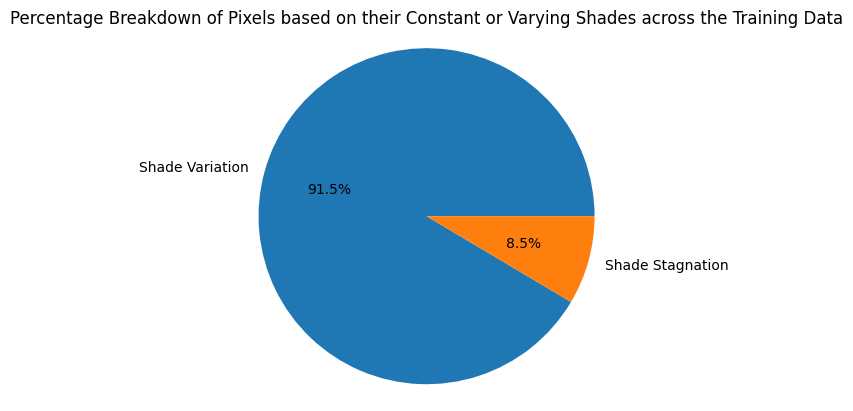

In [ ]:
#This produces a pie chart to show the percentage breakdown of the above magnitudes
vals_train = count_mult_train, count_single_train
plt.pie(vals_train, labels=['Shade Variation', 'Shade Stagnation'], autopct='%1.1f%%')
plt.title('Percentage Breakdown of Pixels based on their Constant or Varying Shades across the Training Data')
plt.axis('equal')
plt.show()

The above block confirms that the majority of the pixels do see fluctuation in some capacity with regards to the shade of the pixels. The fact that the few pixels from the outer regions of the image shown in the window from .nunique() saw no change likely indicates that a strong portion of the 67 pertain to the outer regions of the 28x28 image. I will repeat the same process to explore the test set in the following blocks.


In [ ]:
df_test.nunique()

Pixel 1       1
Pixel 2       1
Pixel 3       1
Pixel 4       1
Pixel 5       1
             ..
Pixel 781     1
Pixel 782     1
Pixel 783     1
Pixel 784     1
Labels       10
Length: 785, dtype: int64

Similar to the training data as would be expected

In [ ]:
#This block contains the code to check how many pixels in the test data remain white across the images and how amny change shade
count_mult_test = 0
count_single_test = 0
for i in df_test.nunique():
  if i != 1:
    count_mult_test += 1
  if i == 1:
    count_single_test += 1
print(f'There are {count_mult_test} pixels which have more than one fluctuation in shade across the images')
print(f'There are {count_single_test} pixels which have no changes in shade across the images')

There are 669 pixels which have more than one fluctuation in shade across the images
There are 116 pixels which have no changes in shade across the images


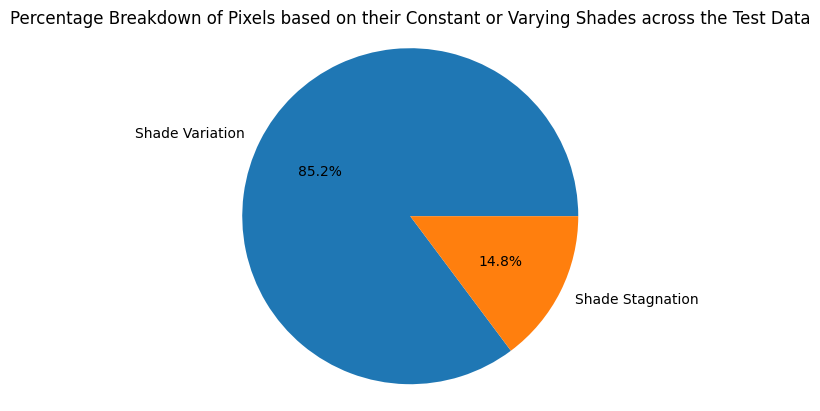

In [ ]:
#This produces a pie chart to show the percentage breakdown of the above magnitudes
vals = count_mult_test, count_single_test
plt.pie(vals, labels=['Shade Variation', 'Shade Stagnation'], autopct='%1.1f%%')
plt.title('Percentage Breakdown of Pixels based on their Constant or Varying Shades across the Test Data')
plt.axis('equal')
plt.show()

From the above results, the test data has more pixels which do not experience a change from white across the images. This makes sense though since it only has 1/7 of the images while the training has 6/7 which essentially gives the test data less opportunities for an image to alter a pixel, especially for those which see a few changes even in the training. Pixels of this nature would be more prone to remain constant in their shade in this scenario for the test data

In [ ]:
#This explores how often we see pixels have a certain amount of diffeent shades across the entire training images.
#For example, we see below that 396 pixels see their 256 different shade values across the training set.
pixel_values_count_train = df_train.nunique().value_counts()
pixel_values_count_train

256    396
1       67
2       17
3       17
255     16
      ... 
21       1
154      1
156      1
247      1
13       1
Length: 150, dtype: int64

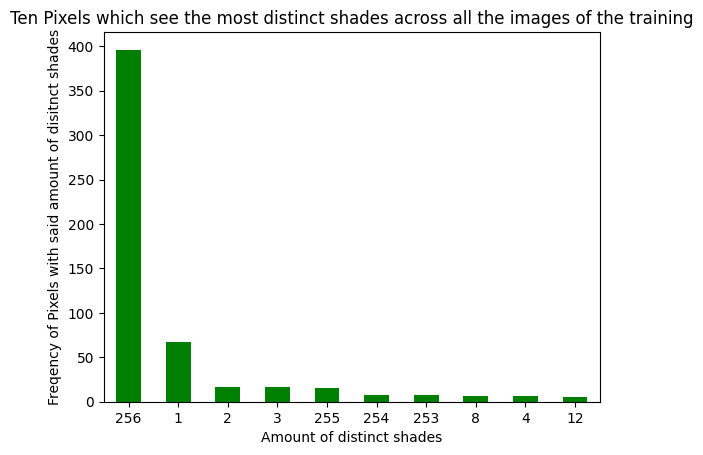

In [ ]:
import matplotlib.pyplot as plt

#This plots amount of pixels which see the stated disitnct shades for the training. These are the top 10 which see the largest amount of pixels come to
pixel_values_count_train.iloc[:10].plot(kind='bar', color='green')
plt.title('Ten Pixels which see the most distinct shades across all the images of the training')
plt.xlabel('Amount of distinct shades')
plt.ylabel('Freqency of Pixels with said amount of disitnct shades')
plt.xticks(rotation=360)
plt.show()

In [ ]:
#As above but for the test set. See how many pixels see a certain amount of different shade values
pixel_values_count_test = df_test.nunique().value_counts()
pixel_values_count_test

256    227
1      116
255     27
2       19
3       15
      ... 
188      1
126      1
44       1
163      1
39       1
Length: 171, dtype: int64

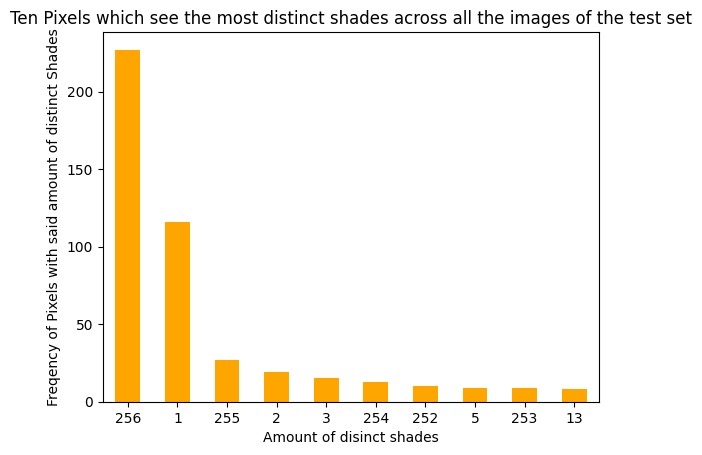

In [ ]:
import matplotlib.pyplot as plt
#This plots amount of pixels which see the stated disitnct shades for the test. These are the top 10 which see the largest amount of pixels come to
pixel_values_count_test.iloc[:10].plot(kind='bar', color='orange')
plt.title('Ten Pixels which see the most distinct shades across all the images of the test set')
plt.xlabel('Amount of disinct shades')
plt.ylabel('Freqency of Pixels with said amount of distinct Shades')
plt.xticks(rotation=360)
plt.show()

In [ ]:
#This block is to show what digit is drawn the most in the training set
train_label_counts = df_train['Labels'].value_counts()
train_label_counts

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: Labels, dtype: int64

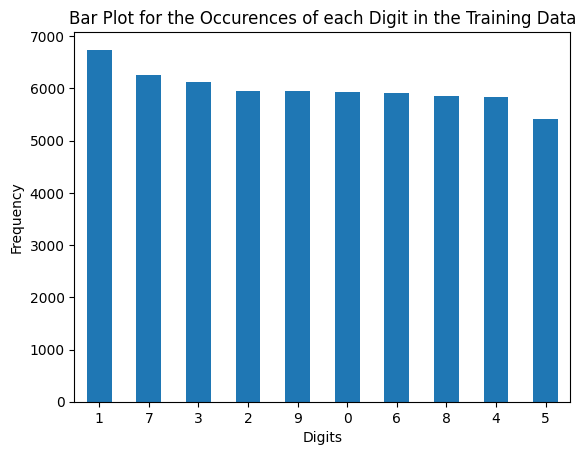

In [ ]:
import matplotlib.pyplot as plt
#Here I plot the freqeuncy of each digit in the training set. Variation is present however each has a sizeable amount of correspodning images
train_label_counts.plot(kind='bar')
plt.title('Bar Plot for the Occurences of each Digit in the Training Data')
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.xticks(rotation=360)
plt.show()

In [ ]:
#This shows how common each digit is in the test set, we can see differences when compared to the training
test_label_counts = df_test['Labels'].value_counts()
test_label_counts

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: Labels, dtype: int64

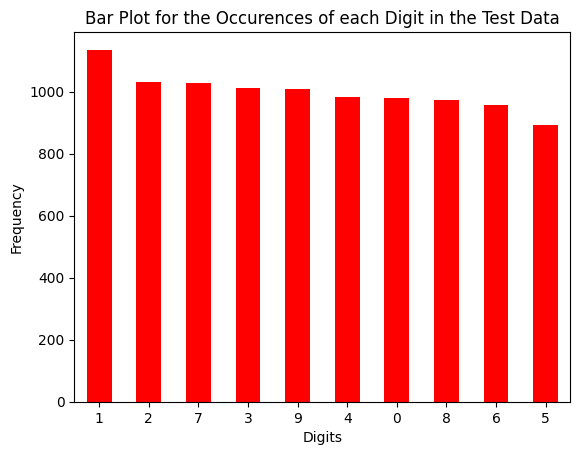

In [ ]:
#Here I plot the freqeuncy of each digit in the test set. Variation is present however each has a sizeable amount of correspodning images.
#Can note the differences compared to the trainng in this context
test_label_counts.plot(kind='bar', color='Red')
plt.title('Bar Plot for the Occurences of each Digit in the Test Data')
plt.xlabel('Digits')
plt.ylabel('Frequency')
plt.xticks(rotation=360)
plt.show()

In [ ]:
#This block is to see the which pixels tend to see their values fluctuate trenemdously based on their std devs in the training
st_devs_train = {}
for i in df_train:
  if i == 'Labels':
    continue
  st_devs_train[i]=df_train[i].std()
st_devs_train = sorted(st_devs_train.items(), key=lambda pairs: pairs[1], reverse=True)
print("Here are the 10 Pixels which see the largest standard deviation in their shade values across the images of the training data")
#Here I print the 10 pixels in descending order for the training data
for i, runs in zip(st_devs_train, range(10)):
  print(i)

Here are the 10 Pixels which see the largest standard deviation in their shade values across the images of the training data
('Pixel 379', 0.44632944227736576)
('Pixel 407', 0.44599273693516367)
('Pixel 462', 0.44285203224235475)
('Pixel 628', 0.4425744203370796)
('Pixel 463', 0.4417430820069913)
('Pixel 435', 0.44163189022377275)
('Pixel 438', 0.4416234982810556)
('Pixel 434', 0.44160184483924775)
('Pixel 629', 0.44098274313282215)
('Pixel 410', 0.4407020719866242)


In [ ]:
#This block is to see the which pixels tend to see their values fluctuate trenemdously based on their std devs in the test
st_devs_test = {}
for i in df_test:
  if i == 'Labels':
    continue
  st_devs_test[i]=df_test[i].std()
st_devs_test = sorted(st_devs_test.items(), key=lambda pairs: pairs[1], reverse=True)
print("Here are the 10 Pixels which see the largest standard deviation in their shade values across the images of the test data")
#This prints the ten ixels in descending order for test data
for i, runs in zip(st_devs_test, range(10)):
  print(i)

Here are the 10 Pixels which see the largest standard deviation in their shade values across the images of the test data
('Pixel 379', 0.44825236880530533)
('Pixel 407', 0.4467899422262074)
('Pixel 628', 0.44464247324443945)
('Pixel 438', 0.4444426859258407)
('Pixel 410', 0.4443216672844819)
('Pixel 462', 0.4438065938573977)
('Pixel 434', 0.44313964851261256)
('Pixel 463', 0.44303164089796127)
('Pixel 629', 0.44287987815671015)
('Pixel 465', 0.44228999979283784)


# Modeling

In order to execute the solution to the Data Science Problem presented above, I will employ four modeling techniques, k-NN classification, a Multi-Layer Perceptron Neural Network, a Convolutional Neural Network, and a Feedforward Neural Network. One of these techniques, k-NN is a traditional machine learning method with the other three variations of deep learning neural networks which each offer a unique manner of assessing the data. Each of these models will be compared against one another to establish a rough baseline standard for performance and determine which sees optimal performance based on a multitude of metrics as detailed in classification reports. In addition, I will consider various additional components of the context surrounding each one to evaluate which could be projected to have the most viability in deployment scenarios.


In [ ]:

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [ ]:
#This seperates the training and test sets into that pof the input features and the target variable by sinmply referencing the approporiate columns for each
x_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]
x_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]


k-NN Modeling

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report


#Here I train a k-NN model based on the training, predict on the test, and evaluate said predictions to portray a classification report detailing performance metrics
#This model assess the classifications based on the 5 classifed points, aka neighbors, with the closesnt proximity to each point being classified
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train, y_train)
digit_preds_knn = knn_classifier.predict(x_test)
eval_knn = classification_report(y_test, digit_preds_knn)


print(eval_knn)


              precision    recall  f1-score   support

           0       0.96      0.99      0.98       980
           1       0.95      1.00      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



Multi-Layer Perceptron Classifier Modeling

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

#This is to train, test, and evaluate a Multi Layer Perceptron Neural Network using the cleaned MNIST training and test data before displaying the results via a classification report
#For this MLP i configure it to have one hidden layer of 100 neurons, 250 maximum forward and backward runs (iterations) through the data, and a random state of 50 for reproducability
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=250, random_state=50)
mlp_classifier.fit(x_train, y_train)
digit_preds_mlp = mlp_classifier.predict(x_test)
eval_mlp = classification_report(y_test, digit_preds_mlp)

print(eval_mlp)


              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.97      0.97       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

#Here I build my CNN architecture by leveraging keras sequential model as the outer framework, indicating the models will be stacked for processing to occur sequentially
#CNN works rather well with image data and therfore can uptake the data as a 28x28 arranged array. I will convert to this shape in the modeling (the next block)
model_CNN = models.Sequential([
    #The first convolutional layer has 32 filters with a 3 by 3 kernel, relu activation to pick up nonlinearity, and an input shape aligned with the 28x28 pixel data
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    #Here I implement a pooling layer to lower the dimensionality of the 32 feature maps from each filter from 26x26 as a product fo the kernerl to 13x13.
    #This essentially streamlines the process by extracting the features of the feature maps which are most relevant to the CNN
    layers.MaxPooling2D((2, 2)),
    #The second convolutional layer has 64 filters with, again, a 3 by 3 kernel, relu activation to pick up nonlinearity. Identically configured max pooling as above
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #The third convolutional layer is essenitally another iteration of the previous layer when viewing configuration however the input it will work on will
    #different and this does not incoroproate pooling. I intend to make full use of the fetaure maps as they result from this final CNN layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    #This flatten layer, as one would expect, flattens the output into a single dimensional vector since the dense layers require input of this nature
    layers.Flatten(),
    #Now the flattened output of the CNN layers is passed through a dense layer of 64 neurons configured with relu acvitation for nonlinearity
    layers.Dense(64, activation='relu'),
    #The final product of this sequential procedure is outputted via 10 neurons, oen for each class, with softmax for normalized probabilites to each class so a determined class can be associated.
    layers.Dense(10, activation='softmax')
])

#This archiecture as described above is further compiled via adam optimizer, the sparse categorical crossentropy given the classifcation goal, and acccuracy as a metric
model_CNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#I depict a summary of the CNN architecture below
model_CNN.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 3, 3, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 576)              

In [ ]:
#This converts the labeled digits to integers, a preferred state for the CNN
int_y_test = y_test.astype(int)
int_y_train = y_train.astype(int)

In [ ]:
#CNN works rather well for image in its inate spatial 2d nature. Therefore, I employ a mehtod of reconverting the flattened pixels to their 28x28 format for this cnn
cnn_aligned_train = x_train.values.reshape(-1,28,28,1)
cnn_aligned_test = x_test.values.reshape(-1,28,28,1)
#This fits the model below to the training data using 10 epochs, a batch_size of 32 and the test for validation
fit_CNN = model_CNN.fit(cnn_aligned_train, int_y_train, batch_size = 32, epochs=10, validation_data=(cnn_aligned_test, int_y_test))
#Here I set two variables to gatehr the loss and mertic, here accuracy for the CNN based in how the fitted model would perform on the test
test_loss, test_accuracy = model_CNN.evaluate(cnn_aligned_test, int_y_test)
#I sought to produce a classification reprot and therefore needed to have tangible predicstions as a variable so I gather the 10 outputs here and set the
#highets probability label by argmax to be the models determined prediction before using this to prodice a classification report
y_pred = model_CNN.predict(cnn_aligned_test)
digit_preds_cnn = tf.argmax(y_pred, axis=1)
eval_cnn = classification_report(int_y_test, digit_preds_cnn.numpy())
print(eval_cnn)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1875/1875 [==============================] - 184s 98ms/step - loss: 0.1419 - accuracy: 0.9561 - val_loss: 0.0542 - val_accuracy: 0.9816
Epoch 2/10
1875/1875 [==============================] - 177s 94ms/step - loss: 0.0467 - accuracy: 0.9851 - val_loss: 0.0376 - val_accuracy: 0.9865
Epoch 3/10
1875/1875 [==============================] - 175s 94ms/step - loss: 0.0333 - accuracy: 0.9898 - val_loss: 0.0308 - val_accuracy: 0.9891
Epoch 4/10
1875/1875 [==============================] - 173s 92ms/step - loss: 0.0251 - accuracy: 0.9924 - val_loss: 0.0316 - val_accuracy: 0.9898
Epoch 5/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.0190 - accuracy: 0.9941 - val_loss: 0.0460 - val_accuracy: 0.9857
Epoch 6/10
1875/1875 [==============================] - 170s 91ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 0.0374 - val_accuracy: 0.9894
Epoch 7/10
1875/1875 [==============================] - 171s 91ms/step - loss: 0.0128 - accuracy: 0.9960 - val_loss: 0.0292 - val

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

#Again I leverage the sequential fraemwork for neural entwork of keras to build a FNN based on layers which stack on oen another
model_FNN = models.Sequential([
    #This layer is it uptake the data as a 784 dimesnions single array input, differetn from CNN as the dense layers woudl require this
    layers.Flatten(input_shape=(784,)),
    #Inital dense layer of 128 neurons and relu activiation for nonlinearity caputring
    layers.Dense(128, activation='relu'),
    #Fully connected bu tthis time of 64 neruons with the relua ctivation to enhacne the ability of inritcate patterns to be gathered
    layers.Dense(64, activation='relu'),
    #The final product of this sequential procedure is outputted via 10 neurons, oen for each class, with softmax for normalized probabilites to each class so a determined class can be associated.
    layers.Dense(10, activation='softmax')
])

#This compiles the model by the same configurations of paramnters as the CNN before with sepcifcs being employed for analogous reasonings
model_FNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#Here I show the structure of the FNNas I did with the CNN before
model_FNN.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               100480    
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
Total params: 109386 (427.29 KB)
Trainable params: 109386 (427.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#This trains and tests the mdoel in the manner as per the CNN. The classificaationnreport is seperated into a seperate code block though
model_FNN.fit(x_train, int_y_train, epochs=10, validation_data=(x_test, int_y_test))
test_loss, test_accuracy = model_FNN.evaluate(x_test, int_y_test)
print(f'Test accuracy: {test_accuracy}')

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1875/1875 [==============================] - ETA: 0s - loss: 0.2391 - accuracy: 0.9298

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1875/1875 [==============================] - 93s 50ms/step - loss: 0.2391 - accuracy: 0.9298 - val_loss: 0.1114 - val_accuracy: 0.9663
Epoch 2/10
1875/1875 [==============================] - 82s 44ms/step - loss: 0.1032 - accuracy: 0.9685 - val_loss: 0.0964 - val_accuracy: 0.9689
Epoch 3/10
1875/1875 [==============================] - 81s 43ms/step - loss: 0.0717 - accuracy: 0.9780 - val_loss: 0.1034 - val_accuracy: 0.9682
Epoch 4/10
1875/1875 [==============================] - 84s 45ms/step - loss: 0.0559 - accuracy: 0.9824 - val_loss: 0.0932 - val_accuracy: 0.9721
Epoch 5/10
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0430 - accuracy: 0.9862 - val_loss: 0.0719 - val_accuracy: 0.9758
Epoch 6/10
1875/1875 [==============================] - 78s 42ms/step - loss: 0.0364 - accuracy: 0.9880 - val_loss: 0.0786 - val_accuracy: 0.9761
Epoch 7/10
1875/1875 [==============================] - 78s 41ms/step - loss: 0.0291 - accuracy: 0.9904 - val_loss: 0.0715 - val_accura

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 5s 17ms/step - loss: 0.0870 - accuracy: 0.9792
Test accuracy: 0.979200005531311


In [ ]:
#This blokc houses the production of the classification report for the FNN. It outputs the 10 probabilites for the each class and aggregates the max for the employed prediction
y_pred_FNN = model_FNN.predict(x_test)
digit_preds_FNN = tf.argmax(y_pred_FNN, axis=1)
eval_FNN = classification_report(int_y_test, digit_preds_FNN.numpy())
print(eval_FNN)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


  1/313 [..............................] - ETA: 39s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


313/313 [==============================] - 4s 12ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.97      0.98      1010
           4       0.96      0.99      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.99      0.98       958
           7       0.98      0.98      0.98      1028
           8       0.97      0.98      0.97       974
           9       0.99      0.95      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



# Results and Evaluation


When delving into the results from the four models which I employed, each performs rather well with the accuracies of 97%, 98%, 99%, and 98% for the k-NN, MLP, CNN, and FNN models respectively. These are all excellent results with further metrics such as precision, recall, f-1 score, etc, shown in the classification report for each digit, all of which serve to further substantiate strong performance for each model. The confusion matrix for each is visualized below detailing the magnitudes of each prediction vs actual value combination for every digit label. These provide aesthetic visuals to reinforce the excellent manner in which these models performed on the data.

Upon observation of the specific metrics corresponding to each digit within the classification reports, we can see patterns among the four models with regards to the digits which see slightly higher scores and those which lag behind. The digit 1 sees consistent upper end scoring which when considered is rather reasonable as the arrangement of pixels to depict this digit is simpler in comparison to other digits. On the contrary, 9 saw lesser performance for three of the models, although at or above .95, however the CNN model which saw the stri=ongest scoring saw virtually no decrease in valuation metrics for 9. This can likely be attributed to CNN's complexity and ability to capture intricate patterns in a more effective capacity.

Although CNN scored the best of the four models, I would not necessarily advise its usage in deployment due to it being the most computationally intensive of the four. The k-NN model, although the poorest performer, is attributed this description by a .97 accuracy which while the worst is so by a minimal amount. As a result, the substantial improvement in computational usage could see this model to be more functional in deployment scenarios especially in those which have restrictions in terms of processing ability. In sum, each of these models offers an intriguing balance between their processing and their performance and in order to advise which would be the most suitable, the specifics of a hypothetical deployment scenario would have to be considered. For example, this MNIst dataset is, compared to other image data, less complex which could play a substantial role in why a simpler k-NN model rendered comparable classifying ability to that of the more complex neural networks. In future work, if the dataset exhibits more pixels with said pixels arranged in a more varying and intricate manner, the neural networks would likely distinguish themselves more as a k-NN model may not have the means of capturing such complexities. This is hypothetical and not necessarily a guarantee however it opens the door for routes of future work where analogous k-NN, MLP, CNN, and FNN models could be configured, applying, and evaluated against such data.


In [ ]:

#I import the confusion martix function from scikit leanr to visualize the performance of the models in classifying images
from sklearn.metrics import confusion_matrix






k-NN Results

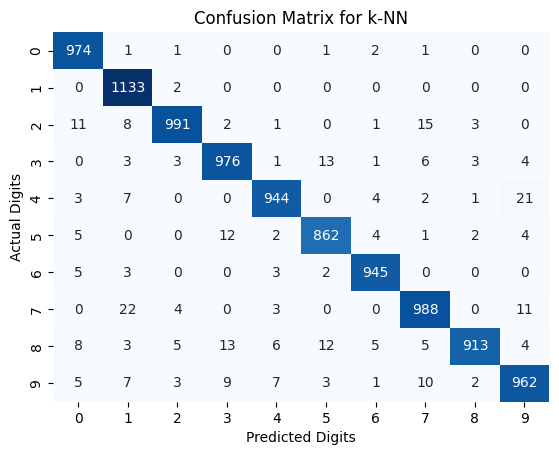

In [ ]:
#This computes and displays the confusion matrix to portray the performance of the k-NN model
knn_conf_matrix = confusion_matrix(y_test, digit_preds_knn)
sns.heatmap(knn_conf_matrix, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Digits')
plt.ylabel('Actual Digits')
plt.title('Confusion Matrix for k-NN')
plt.show()

MLP Classifer Results

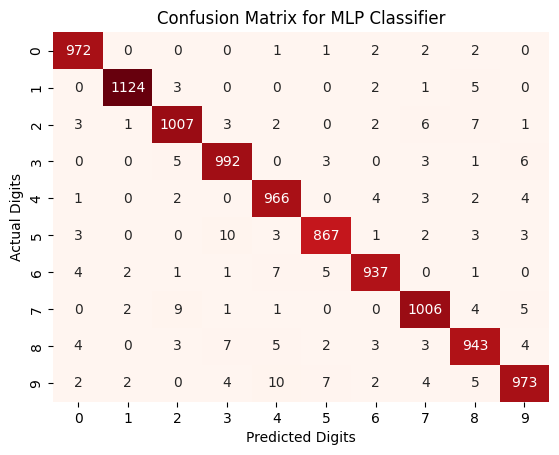

In [ ]:
#This computes and displays the confusion matrix to portray the performance of the Multi-Layer Perceptron model
mlp_conf_matrix = confusion_matrix(y_test, digit_preds_mlp)
sns.heatmap(mlp_conf_matrix, annot=True, cmap='Reds', fmt='g', cbar=False)
plt.xlabel('Predicted Digits')
plt.ylabel('Actual Digits')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

CNN Results

In [ ]:
#Here I convert the numerical predictions of the CNN to string values as there were issues wiht the computation of the confusion matrix using the numerical values
cnn_preds = digit_preds_cnn.numpy()
cnn_preds_str = []
for i in cnn_preds:
  cnn_preds_str.append(str(i))

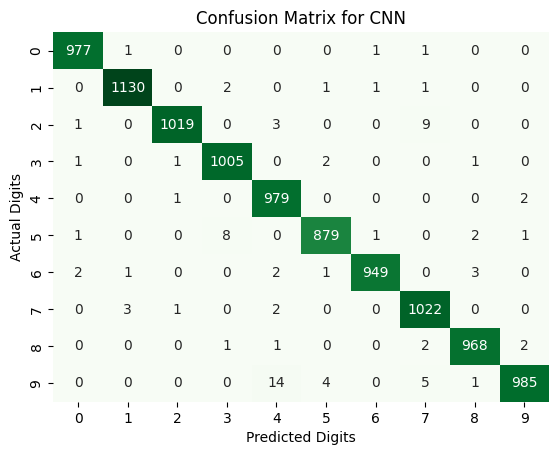

In [ ]:
#This computes and displays the confusion matrix to portray the performance of the CNN model using the converted predicitons from above
CNN_conf_matrix = confusion_matrix(y_test, cnn_preds_str)
sns.heatmap(CNN_conf_matrix, annot=True, cmap='Greens', fmt='g', cbar=False)
plt.xlabel('Predicted Digits')
plt.ylabel('Actual Digits')
plt.title('Confusion Matrix for CNN')
plt.show()

FNN Results

In [ ]:
#Here I convert the numerical predictions of the FNN to string values as there were issues wiht the computation of the confusion matrix using the numerical values
FNN_preds = digit_preds_FNN.numpy()
FNN_preds_str = []
for i in FNN_preds:
  FNN_preds_str.append(str(i))

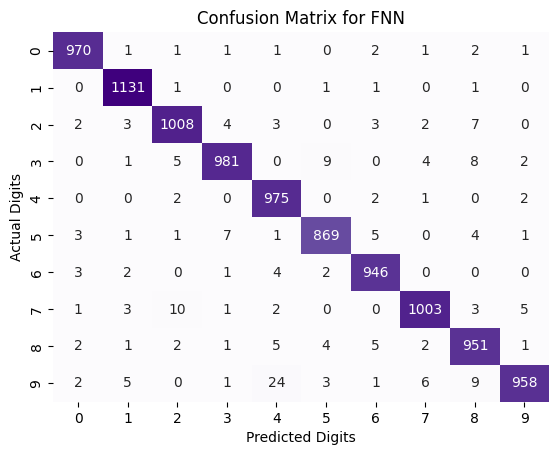

In [ ]:
#This computes and displays the confusion matrix to portray the performance of the FNN model using the converted predicitons from above
FNN_conf_matrix = confusion_matrix(y_test, FNN_preds_str)
sns.heatmap(FNN_conf_matrix, annot=True, cmap='Purples', fmt='g', cbar=False)
plt.xlabel('Predicted Digits')
plt.ylabel('Actual Digits')
plt.title('Confusion Matrix for FNN')
plt.show()